In [0]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [43]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        # read all text
        text = file.read()
        file.close()
        return text

# split a text into sentences
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

#take only 120,000 lines
deu_eng = deu_eng[:120000,:]
deu_eng

#remove punctuations and convert to lower case
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]


# prepare regex for char filtering
re_print = re.compile('[^%s]' % re.escape(string.printable))
# remove non-printable chars form each token
deu_eng[:,0] = [re_print.sub('', w) for w in deu_eng[:,0]]
deu_eng[:,1] = [re_print.sub('', w) for w in deu_eng[:,1]]

# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

array([['hi', 'hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['hi', 'gr gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ['run', 'lauf',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #941078 (Fingerhut)'],
       ...,
       ['tom organized his cds by artist',
        'tom sortierte seine cds nach knstlern',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #681668 (Source_VOA) & #764513 (Pfirsichbaeumchen)'],
       ['tom ought to do that more often', 'tom sollte das fter tun',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #6221678 (CK) & #6970225 (Pfirsichbaeumchen)'],
       ['tom paid off his gambling debts',
        'tom zahlte seine wettschulden ab',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3956121 (CK) & #4007182 (pullnosemans)']],
      dtype='<U537')

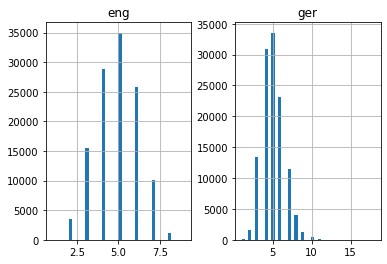

In [44]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'ger':deu_l})

length_df.hist(bins = 40)
plt.show()

In [45]:
# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)
 
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(deu_eng[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print("English max length: %d" % eng_length)

#prepare german tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1
deu_length = max_length(deu_eng[:, 1])
print('German Vocabulary Size: %d' % deu_vocab_size)
print("German max length: %d" % deu_length)

English Vocabulary Size: 10585
English max length: 9
German Vocabulary Size: 19602
German max length: 18


In [0]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

# prepare training data get input as english and output as german
trainX = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_sequences(deu_tokenizer, deu_length, train[:, 1])

# prepare validation data
testX = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_sequences(deu_tokenizer, deu_length, test[:, 1])

In [0]:
# build NMT model
from keras.layers import Bidirectional, Dropout
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(Bidirectional(LSTM(units)))
      model.add(RepeatVector(out_timesteps))
      model.add(Bidirectional(LSTM(units, return_sequences=True)))
      model.add(Dropout(0.5))
      model.add(Bidirectional(LSTM(units, return_sequences=True)))
      model.add(Dropout(0.5))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

# model compilation
model = define_model(eng_vocab_size, deu_vocab_size,  eng_length, deu_length, 256)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [0]:
filename = 'model_bi_lstm.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=40, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

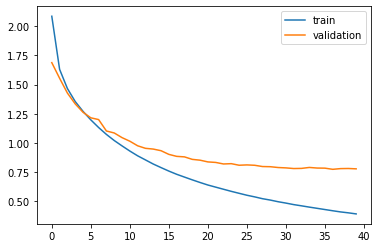

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [0]:
model = load_model('model_bi_lstm.h5')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [37]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None


preds_text = []
for i in preds[:30]:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], deu_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], deu_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 
       preds_text.append(' '.join(temp))
       

pred_df = pd.DataFrame({'english' : test[:30,0], 'german (predicted)' : preds_text, 'german (actual)' : test[:30,1],})
pred_df.sample(30)

,english,german (predicted),german (actual)
0,its raining again,es regnet wieder,es regnet wieder
6,he attempted to escape,er versuchte sich zu,er versuchte zu entkommen
27,tom is excited about it,tom ist gleich,tom ist davon begeistert
2,you seem unreliable,du scheinen sich zu,ihr scheint unzuverlssig zu sein
25,you were totally right,du hattest vollkommen recht,ihr hattet vollkommen recht
7,theyll be fine,sie werden es klarkommen,es wird ihnen gutgehen
5,were ready when you are,wir sind bereit wenn sie sind,wir sind bereit wenn du es bist
1,reality is scary,dies ist verboten,die wirklichkeit ist bengstigend
28,what a strange guy,was fr ein toller mann,was fr ein komischer typ
29,he is quite right,er hat recht,er hat vllig recht
